In [40]:
import json 
import math
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [41]:
#define a function to read the features
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

#define a function to read the statistical values di un df
def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

#define a function to compute the root mean square log error 
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [42]:
#description of the apartments
apartments = pd.read_csv('apartments_train.csv')
print(f'Loaded {len(apartments)} apartments')
with open('apartments_meta.json') as f: 
    apartments_meta = json.load(f)

Loaded 23285 apartments


In [43]:
#description of the buildings
buildings = pd.read_csv('buildings_train.csv')
print(f'Loaded {len(buildings)} buildings')
with open('buildings_meta.json') as f: 
    buildings_meta = json.load(f)


Loaded 6791 buildings


In [44]:
#merge the due dataset using the building_id 
print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

All apartments have an associated building: True


In [45]:
#do the same process with the data_test
apartments_test = pd.read_csv('apartments_test.csv')
buildings_test = pd.read_csv('buildings_test.csv')
print(f'All test apartments have an associated building: {apartments_test.building_id.isin(buildings_test.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
print(f'Number of train samples: {len(data)}')
print(f'Number of test samples:  {len(data_test)}')
data_test.tail()

All test apartments have an associated building: True
Number of train samples: 23285
Number of test samples:  9937


,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
9932,33217,3.0,106.0,19.9,56.7,16.0,3.0,NaN,3.3,NaN,...,10А,2020.0,2.0,20.0,0.0,1.0,1.0,0.0,NaN,0.0
9933,33218,NaN,82.0,NaN,NaN,3.0,3.0,NaN,NaN,2.0,...,к1,2021.0,2.0,20.0,0.0,1.0,1.0,1.0,NaN,NaN
9934,33219,NaN,49.3,NaN,NaN,15.0,1.0,NaN,0.0,NaN,...,70к5,2016.0,2.0,24.0,0.0,1.0,1.0,0.0,1.0,1.0
9935,33220,NaN,38.8,10.5,15.1,14.0,1.0,NaN,3.3,1.0,...,1,2019.0,NaN,14.0,1.0,1.0,1.0,0.0,1.0,NaN
9936,33221,1.0,71.5,7.0,49.0,2.0,3.0,NaN,NaN,NaN,...,2,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


# DATA PREPROCESSING

In [46]:
id_test=data_test['id']


In [47]:
#point 2
# id feature is pointless for the analysis of the price since it changes for each sample
del data['id']
del data_test['id']
# street and address features are pointless becuase we have latitude and longitude
del data['street']
del data_test['street']
del data['address']
del data_test['address']

In [48]:
#point 3
# layout is pointless because for the largest number of the samples this features is NaN
del data['layout']
del data_test['layout']


In [49]:
#point 5.a 
# firstly samples with NaN values for the features 'bathroom_shared' and 'bathroom_private' have been deleted and then the heatmap is displayed only for these two attributes
#bathroom_share is strongly correlated with bathroom_private: the coefficient is -0.61 (the correlation is inverse).
#so the feature 'bathrooms_shared' has been deleted. 
df = data[data['bathrooms_shared'].notna()]
df = df[df['bathrooms_private'].notna()]
prova=df[['bathrooms_shared','bathrooms_private']]


In [50]:
del data["bathrooms_shared"]
del data_test["bathrooms_shared"]

In [51]:
#point 5.b 
# firstly samples with NaN values for the features 'balconies' and 'loggias' have been deleted and then the heatmap is displayed only for these two attributes
#balconies is strongly correlated with loggias: the coefficient is -0.7(the correlation is inverse).
#so the feature 'loggias' has been deleted. 
df = data[data['balconies'].notna()]
df = df[df['loggias'].notna()]

In [52]:
del data["loggias"]
del data_test["loggias"]


In [53]:
#point 5.c 

df = data[data['area_living'].notna()]
df = df[df['area_total'].notna()]

In [54]:
del data["area_living"]
del data_test["area_living"]


In [55]:
#point 5.d

df = data[data['rooms'].notna()]
df = df[df['area_total'].notna()]

In [56]:
del data["rooms"]
del data_test["rooms"]

In [57]:
#point 5.e

df = data[data['seller'].notna()]
df = df[df['new'].notna()]

In [58]:
del data["seller"]
del data_test["seller"]

In [59]:
#point 5.f

df = data[data['elevator_service'].notna()]
df = df[df['constructed'].notna()]

In [60]:
del data["elevator_service"]
del data_test["elevator_service"]

In [61]:
#point 5.g

df = data[data['new'].notna()]
df = df[df['constructed'].notna()]

In [62]:
del data["constructed"]
del data_test["constructed"]

In [63]:
#point 5.h 

df = data[data['stories'].notna()]
df = df[df['floor'].notna()]

In [64]:
del data["stories"]
del data_test["stories"]

In [65]:
#point 5.i 

df = data[data['windows_court'].notna()]
df = df[df['windows_street'].notna()]

In [66]:
del data["windows_court"]
del data_test["windows_court"]

In [67]:
#point 6
# new is useless because its distribution is almost unique (boolean value = false) and it is not correlated with the price feature
del data['new']
del data_test['new']

In [68]:
#point 7

data['heating']=data['heating'].fillna(0.0)
data_test['heating']=data_test['heating'].fillna(0.0)

In [69]:
#point 8,9
data = data[data['phones'].notna()]
data = data[data['elevator_passenger'].notna()]
data_test['phones'].fillna((data_test['phones'].mean()), inplace=True)
data_test['elevator_passenger']=data_test['elevator_passenger'].fillna(1.0)

In [70]:
#point 10

data = data[data['district'].notna()]
data_test['district']=data_test['district'].fillna(4.0)

In [71]:
# point 11
#ceiling
elencobuilding = data['building_id'].unique().tolist()
for column in elencobuilding:
    dd = data.loc[data['building_id'] == column]['ceiling']
    if dd.sum(axis = 0) - dd.isnull().sum(axis = 0)>0:
        data.loc[data['building_id'] == column]['ceiling'].fillna(data.loc[data['building_id'] == column]['ceiling'].mode()[0])

data['ceiling'].fillna((data['ceiling'].mean()), inplace=True)

In [72]:
#point 12

del data["material"]
del data_test["material"]

In [73]:
#point 13

data['parking']=data['parking'].fillna(3.0)
data_test['parking']=data_test['parking'].fillna(3.0)

In [74]:
#point 14

data['bathrooms_private'].fillna((data['bathrooms_private'].mean()), inplace=True)
data_test['bathrooms_private'].fillna((data_test['bathrooms_private'].mean()), inplace=True)

In [75]:
#point 15

data['elevator_passenger']=data['elevator_passenger'].fillna(-1.0)
data_test['elevator_passenger']=data_test['elevator_passenger'].fillna(-1.0)
data['elevator_without']=data['elevator_without'].fillna(-1.0)
data_test['elevator_without']=data_test['elevator_without'].fillna(-1.0)
data['garbage_chute']=data['garbage_chute'].fillna(-1.0)
data_test['garbage_chute']=data_test['garbage_chute'].fillna(-1.0)
data['windows_street']=data['windows_street'].fillna(-1.0)
data_test['windows_street']=data_test['windows_street'].fillna(-1.0)

In [76]:
#point 16

data_test['longitude'].fillna((data_test['longitude'].mean()), inplace=True)
data_test['latitude'].fillna((data_test['latitude'].mean()), inplace=True)


In [77]:
#point 17

#I created a new df with just the feature where I want to fill in the NaN (area_kitchen) and the feature highly correlated with 
#it because I  want to use just that to apply the k-means. Then I have to replace the original column 'area_kitchen' with the new one

data1=data[['area_kitchen','area_total']]
data_test1=data_test[['area_kitchen','area_total']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=10)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['area_kitchen','area_total'])))])


data1=imputer.fit_transform(data1)
data_test1=imputer.fit_transform(data_test1)


In [78]:
'''x1=data1['area_kitchen']
x1 = x1.reset_index()
data = data.reset_index()
data['area_kitchen'] = x1

x2=data_test1['area_kitchen']
x2 = x2.reset_index()
data_test = data_test.reset_index()
data_test['area_kitchen'] = x2'''

"x1=data1['area_kitchen']\nx1 = x1.reset_index()\ndata = data.reset_index()\ndata['area_kitchen'] = x1\n\nx2=data_test1['area_kitchen']\nx2 = x2.reset_index()\ndata_test = data_test.reset_index()\ndata_test['area_kitchen'] = x2"

In [79]:
# del data['index']
# del data_test['index']

In [80]:
#I have to use a pipeline because otherwise I obtain an array and not a dataframe (I tried to transform the array in a df again,
#but in that case I obtain again the NaN, they are not transformed)

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=10)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['price','area_total','area_kitchen','floor','ceiling','bathrooms_private','windows_street','balconies','condition','phones','building_id','latitude','longitude','district','elevator_without','elevator_passenger','parking','garbage_chute','heating'])))])

imputer2 = Pipeline([("imputer", KNNImputer(n_neighbors=10)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['area_total','area_kitchen','floor','ceiling','bathrooms_private','windows_street','balconies','condition','phones','building_id','latitude','longitude','district','elevator_without','elevator_passenger','parking','garbage_chute','heating'])))])

data=imputer.fit_transform(data)
data_test=imputer2.fit_transform(data_test)

In [81]:
# #before merge the deleted columns into our dataset, it's necessary to apply a reset of the index because they didn't match each
# #other (the last of the data is 22736, while the last of the new vectors is 23283)

# data=data.reset_index(drop=True)

# Transformation

In [82]:
#I can apply a log transformation to the feature 'area_total'. I'd like to do it also for the feature 'ceiling', but it contain
#the value 0 (you can't apply the log with it) and if you try to replace 0=0.001 the resulting log transformation isn't good

data['area_total']=data['area_total'].apply(math.log)
data_test['area_total']=data_test['area_total'].apply(math.log)

# Standardization

In [83]:
#before standardize I have to save the feature 'price' in another array and delete it from the df

y=data['price']
del data['price']
del data['building_id']

del data_test['building_id']

In [84]:
#standardization of all the numerical attributes remained

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(data)
scaled_df = pd.DataFrame(scaler.transform(data))
scaled_df.columns = data.columns

scaler = StandardScaler().fit(data_test)
scaled_df2 = pd.DataFrame(scaler.transform(data_test))
scaled_df2.columns = data_test.columns

In [85]:
X_numerical=scaled_df.iloc[:,:]
X_numerical2=scaled_df2.iloc[:,:]


# DUMMIES for categorical features

In [86]:
# #transform the categorical attributes (street and address) into dummies 

# dummies = pd.get_dummies(df_categorical.astype(str),drop_first=True) 
# dummies2 = pd.get_dummies(df_categorical2.astype(str),drop_first=True) 

In [87]:
# dummies.shape

In [88]:
# X=pd.concat([dummies,X_numerical], axis = 1)
# X2=pd.concat([dummies2,X_numerical2], axis = 1)

In [89]:
# X2.shape

# PCA

(I'm not sure PCA is the best option here)

#PCA fit
from sklearn.decomposition import PCA
# we can choose the number of components e.g. 10, the percentage of the total variance or set it to None (that means it automatically chooses the number of components)
pca2 = PCA(n_components=1)

pca2.fit(data) #The fit learns some quantities from the data, most importantly the "components" and "explained variance"
X = pd.DataFrame(pca2.transform(data))

explained_var=pd.DataFrame(pca2.explained_variance_ratio_).transpose()
%matplotlib inline
ax = sns.barplot( data=explained_var)#i primi due mi danno gia più del 75% di informazioni

cum_explained_var=np.cumsum(pca2.explained_variance_ratio_)
pd.DataFrame(cum_explained_var).transpose()

In [90]:
# pca2.fit(X2)
# X2 = pd.DataFrame(pca2.transform(X2))

# cum_explained_var=np.cumsum(pca2.explained_variance_ratio_)
# pd.DataFrame(cum_explained_var).transpose()

# Separate Train/Test sets

In [91]:
X=X_numerical
X2=X_numerical2

In [92]:
#after importing the necessary library, we can do the splitting between the training and test set, with a percentege of the 
#training equal to 70% of the starting dataset. Moreover, it has been fixed the random seed for replicability by putting the 
#parameter random_state= 123.

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.30, #by default is 75%-25%
                                                    random_state= 123) #fix random seed for replicability

print(X_train.shape, X_test.shape)

(15915, 17) (6822, 17)


In [106]:
# Creating a Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU, BatchNormalization, Dropout, ReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [94]:
model=Sequential([
    
    Dense(1024, input_dim = X_train.shape[1]), 
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(512),  
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.3),

    Dense(512),  
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(units=256), 
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(units=256), 
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.01),

    Dense(units=128), 
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.05),

    Dense(units=128),
    LeakyReLU(), 
    Dropout(0.05),

    Dense(units=1, activation="linear"),
],name="Moscow_Housing",)
model.compile(optimizer=Adam(learning_rate=0.005, decay=5e-4),loss='mse')
checkpoint_name = 'Weights\Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

2021-10-11 15:05:07.764906: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-11 15:05:07.764928: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-11 15:05:07.764945: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (loris-VivoBook-ASUSLaptop-X409JA-X409JA): /proc/driver/nvidia/version does not exist
2021-10-11 15:05:07.765147: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [95]:
model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=1024,
          epochs=500,
          callbacks=callbacks_list, 
          verbose=1)

2021-10-11 15:05:08.008785: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
16/16 [==============================] - 4s 125ms/step - loss: 3184173862879232.0000 - val_loss: 3313075495108608.0000

Epoch 00001: val_loss improved from inf to 3313075495108608.00000, saving model to Weights\Weights-001--3313075495108608.00000.hdf5
Epoch 2/500
16/16 [==============================] - 2s 153ms/step - loss: 3184152119607296.0000 - val_loss: 3313019928969216.0000

Epoch 00002: val_loss improved from 3313075495108608.00000 to 3313019928969216.00000, saving model to Weights\Weights-002--3313019928969216.00000.hdf5
Epoch 3/500
16/16 [==============================] - 2s 152ms/step - loss: 3184098432516096.0000 - val_loss: 3312670157570048.0000

Epoch 00003: val_loss improved from 3313019928969216.00000 to 3312670157570048.00000, saving model to Weights\Weights-003--3312670157570048.00000.hdf5
Epoch 4/500
16/16 [==============================] - 2s 146ms/step - loss: 3183988105543680.0000 - val_loss: 3312678747504640.0000

Epoch 00004: val_loss did not improve 

<AxesSubplot:>

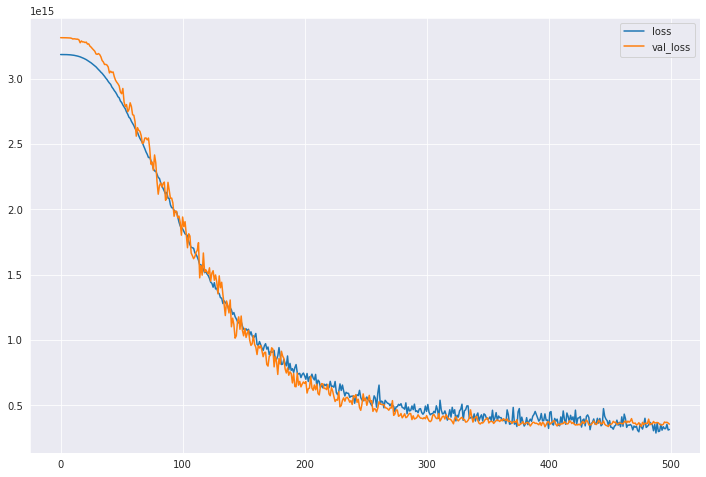

In [96]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))

MAE: 5320015.801885216
MSE: 357047483340206.5
RMSE: 18895700.12834154
VarScore: 0.8712079007279457


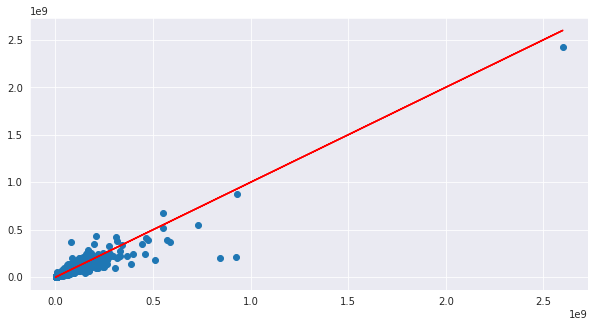

In [97]:
y_pred = model.predict(X_test)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')

In [98]:
list(set(X2) - set(X))
X2=X2[X.columns]
y_pred2= model.predict(X2)
X2['target']=y_pred2

target
-48472500.0     1
-45001668.0     1
-42532156.0     2
-37703300.0     1
-31596762.0     1
               ..
 528687232.0    1
 529740640.0    1
 558864512.0    1
 604630336.0    1
 748359296.0    1
Length: 9618, dtype: int64


Index(['area_total', 'area_kitchen', 'floor', 'ceiling', 'bathrooms_private',
       'windows_street', 'balconies', 'condition', 'phones', 'latitude',
       'longitude', 'district', 'elevator_without', 'elevator_passenger',
       'parking', 'garbage_chute', 'heating', 'target'],
      dtype='object')

In [99]:
predictions=pd.DataFrame()

predictions['id']=id_test
predictions['price_prediction']=y_pred2

predictions.to_csv('predictions.csv', index=False)

Epoch 1/500
125/125 [==============================] - 1s 4ms/step - loss: 3184177084104704.0000 - val_loss: 3313279237619712.0000

Epoch 00001: val_loss improved from inf to 3313279237619712.00000, saving model to Weights\Weights-001--3313279237619712.00000.hdf5
Epoch 2/500
125/125 [==============================] - 1s 4ms/step - loss: 3184145677156352.0000 - val_loss: 3313149851729920.0000

Epoch 00002: val_loss improved from 3313279237619712.00000 to 3313149851729920.00000, saving model to Weights\Weights-002--3313149851729920.00000.hdf5
Epoch 3/500
125/125 [==============================] - 0s 4ms/step - loss: 3183402916249600.0000 - val_loss: 3311340059885568.0000

Epoch 00003: val_loss improved from 3313149851729920.00000 to 3311340059885568.00000, saving model to Weights\Weights-003--3311340059885568.00000.hdf5
Epoch 4/500
125/125 [==============================] - 0s 4ms/step - loss: 3178580204847104.0000 - val_loss: 3302782069112832.0000

Epoch 00004: val_loss improved from 33

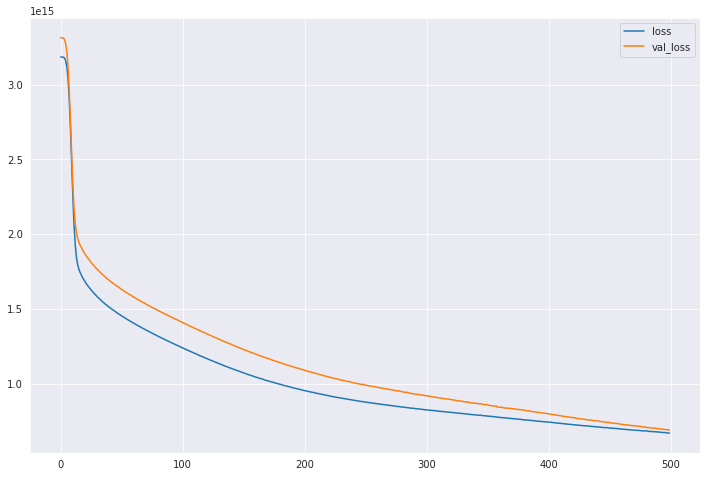

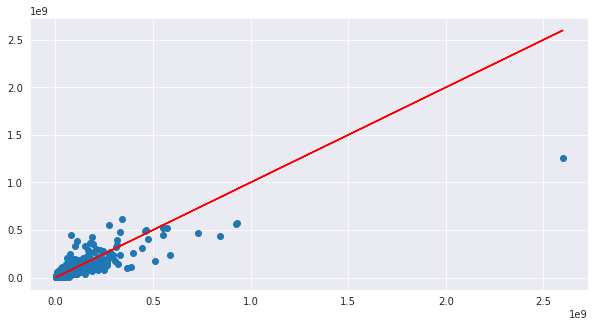

In [110]:
model=Sequential([
    
    Dense(17, input_dim = X_train.shape[1]), 
    ReLU(),
    
    Dense(17),  
    ReLU(),

    Dense(17),  
    ReLU(),
    
    Dense(units=17), 
    ReLU(),

    Dense(units=1, activation="linear"),
],name="Moscow_Housing",)

model.compile(optimizer=Adam(),loss='mse')
checkpoint_name = 'Weights\Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,
          epochs=500,
          callbacks=callbacks_list, 
          verbose=1)

loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))
y_pred = model.predict(X_test)

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')
list(set(X2) - set(X))
X2=X2[X.columns]
y_pred2= model.predict(X2)
X2['target']=y_pred2
predictions=pd.DataFrame()
predictions['id']=id_test
predictions['price_prediction']=y_pred2
predictions.to_csv('predictions.csv', index=False)